Importing Omega_k!=0 package
Running Cosmo Check
NOTE: This cosmology still needs fixing - doesn't work for large values of Ode, but need to check if these are physical values anyway
complexity 0 cosmo_iter 0


/mnt/users/hollowayp/python11_env_new/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/mnt/users/hollowayp/python11_env_new/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


complexity 0 cosmo_iter 1
complexity 0 cosmo_iter 2
complexity 1 cosmo_iter 0
complexity 1 cosmo_iter 1
complexity 1 cosmo_iter 2
complexity 2 cosmo_iter 0
Failed Check: 
Cosmology: w0waCDM(H0=50.0 km / (Mpc s), Om0=0.20000000298023224, Ode0=1.7000000476837158, w0=-0.5, wa=-0.8999999761581421, Tcmb0=0.0 K, Neff=3.04, m_nu=None, Ob0=None)


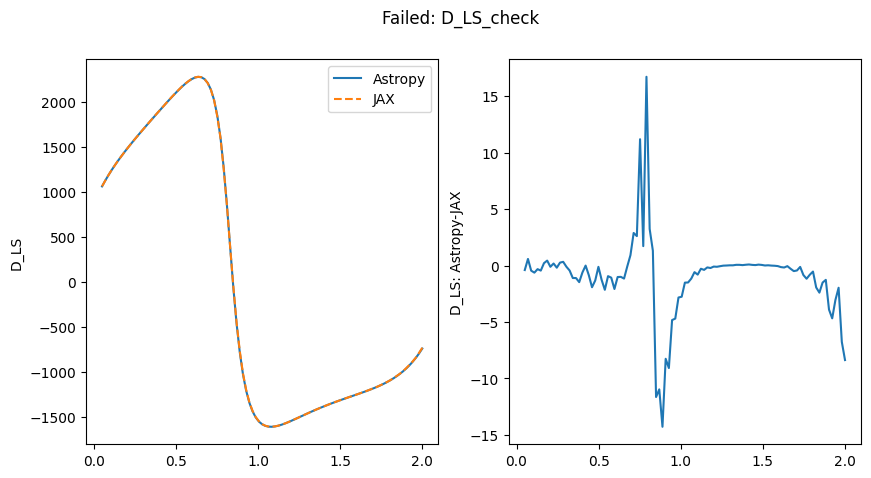

Failed Check (2) 
Cosmology: w0waCDM(H0=50.0 km / (Mpc s), Om0=0.20000000298023224, Ode0=1.7000000476837158, w0=-0.5, wa=-0.8999999761581421, Tcmb0=0.0 K, Neff=3.04, m_nu=None, Ob0=None)


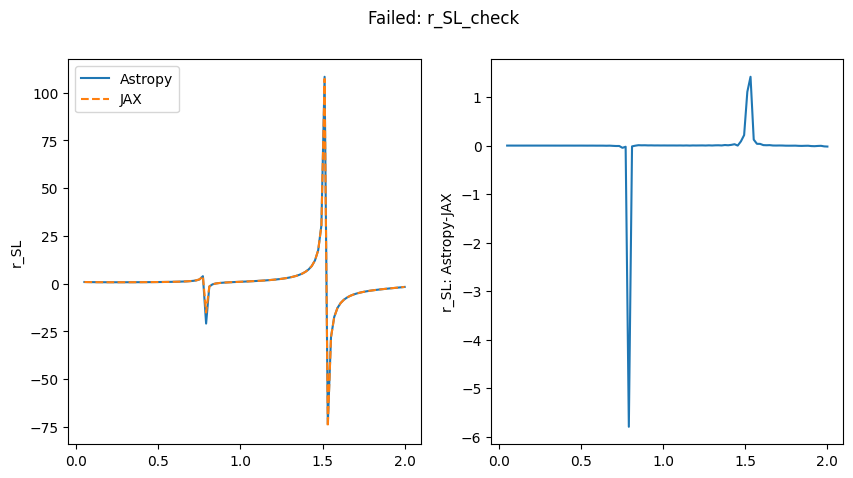

complexity 2 cosmo_iter 1
complexity 2 cosmo_iter 2
Importing Omega_k==0 package
Running Cosmo Check
NOTE: This cosmology still needs fixing - doesn't work for large values of Ode, but need to check if these are physical values anyway
complexity 0 cosmo_iter 0
complexity 0 cosmo_iter 1
complexity 0 cosmo_iter 2
complexity 1 cosmo_iter 0
complexity 1 cosmo_iter 1
complexity 1 cosmo_iter 2
complexity 2 cosmo_iter 0
complexity 2 cosmo_iter 1
complexity 2 cosmo_iter 2
Running Omega_k check


 69%|██████▉   | 162/234 [00:00<00:00, 1126827.94it/s]


In [1]:
from astropy.cosmology import LambdaCDM,FlatLambdaCDM,wCDM,FlatwCDM,w0waCDM
from numpyro import distributions as dist, infer
from numpyro.infer import MCMC, NUTS, HMC
from jax import random,grad, jit
import matplotlib.pyplot as pl
import jax.numpy as jnp
import jax_cosmo as jc
from tqdm import tqdm
import scipy.sparse
import arviz as az
import pandas as pd
import numpy as np
import numpyro
import corner
import emcee
import sys
import jax
from mcmcfunctions_SL_JAX import j_likelihood_SL,run_MCMC
from cosmology_JAX import j_r_SL
#az.style.use('arviz-doc')
#sys.path.append('/Users/hollowayp/zBEAMS')
default_cosmo = jc.Cosmology(Omega_c=0.3,
                            h=0.7,
                            Omega_k=0.0,
                            w0=-1,
                            Omega_b=0,
                            wa=0,
                            sigma8=0.8,
                            n_s=0.96)

In [29]:
import importlib
try:importlib.reload(sys.modules['mcmcfunctions_SL_JAX'])
except Exception as ex: print(f'Cannot reload: {ex}')
from mcmcfunctions_SL_JAX import j_likelihood_SL,run_MCMC

Importing Omega_k!=0 package
Importing Omega_k==0 package
Running Omega_k check


 69%|██████▉   | 162/234 [00:00<00:00, 358185.16it/s]


In [30]:
db_JAX = pd.read_csv('./databases/spectroscopic_db_1perc_1024_samples_100_true_cosmo_FlatwCDM.csv')
db_JAX

,Unnamed: 0,zL_obs,zS_obs,sigma_zL_obs,sigma_zS_obs,r_obs,r_obs_contam,sigma_r_obs,P_tau,FP_bool
0,0,0.175126,1.643355,0.01,0.01,0.855629,0.855629,0.008556,1,0
1,1,0.402902,1.228920,0.01,0.01,0.609905,0.609905,0.006099,1,0
2,2,0.540462,1.304806,0.01,0.01,0.512494,0.512494,0.005125,1,0
3,3,0.459855,1.047246,0.01,0.01,0.503205,0.503205,0.005032,1,0
4,4,0.473083,0.768456,0.01,0.01,0.345713,0.345713,0.003457,1,0
...,...,...,...,...,...,...,...,...,...,...
1019,1019,0.589997,1.290979,0.01,0.01,0.469097,0.469097,0.004691,1,0
1020,1020,0.349510,0.596688,0.01,0.01,0.384891,0.384891,0.003849,1,0
1021,1021,0.509618,0.880321,0.01,0.01,0.374443,0.374443,0.003744,1,0
1022,1022,0.277995,1.167960,0.01,0.01,0.713862,0.713862,0.007139,1,0


In [31]:
N_obs = 1024
zL_obs = jnp.array(np.random.uniform(0.1,0.5,size=N_obs))
zS_obs = jnp.array(np.random.uniform(0.5,1.0,size=N_obs))
sigma_r_obs = 0.01
sigma_r_obs_2 = 100
bool_list = np.random.choice([0,1],p=[0,1],size=N_obs)
P_tau = jnp.array([[0.0,1.0][bool_list[i]] for i in range(len(bool_list))])
print(f'Have mean prob={str(np.round(np.mean(P_tau),2))} and {np.sum(bool_list)} true lensed systems')
r_obs_true = jnp.array(scipy.stats.norm(loc=1,scale=sigma_r_obs).rvs(size=N_obs)*j_r_SL(zL_obs,zS_obs,default_cosmo))
r_obs = jnp.array([np.random.choice(a=[r_obs_true[i],np.random.random()],
                                    p=np.array([np.round(P_tau[i],3),np.round(1-P_tau[i],3)])) for i in range(len(P_tau))])


#sampler_PC = run_MCMC(photometric = True,contaminated = True,cosmo_type='wCDM')
#sampler_P = run_MCMC(photometric = True,contaminated = False,cosmo_type='wCDM')
#sampler_C = run_MCMC(photometric = False,contaminated = True,cosmo_type='wCDM')
sampler_S = run_MCMC(photometric = False,contaminated = True,cosmo_type='FlatwCDM',\
                     zL_obs=jnp.array(db_JAX['zL_obs']),#zL_obs,
                     zS_obs=jnp.array(db_JAX['zS_obs']),#zS_obs,
                     r_obs=jnp.array(db_JAX['r_obs']),#r_obs,
                     sigma_r_obs=jnp.array(db_JAX['sigma_r_obs']),#sigma_r_obs,
                     sigma_r_obs_2=10000.0,#sigma_r_obs_2,
                     P_tau=jnp.array(db_JAX['P_tau']),#P_tau,
                     H0=70.0)


print("BIG QUESTION: Why do I end up with samples for zL and zS? I want to marginalise over these, not get samples of their posteriors "+\
'and/or likelihood? Is the zBEAMS implemtation wrong???? - See tests below - I think this is ok!')
#Useful video on Monte-Carlo Integration: https://www.youtube.com/watch?v=dLLxdMgZgUA&ab_channel=MichelBierlaire
#In summary, you can represent an integral by taking samples from the distribution, then taking the mean.

Have mean prob=1.0 and 1024 true lensed systems


/mnt/users/hollowayp/python11_env_new/lib/python3.11/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


TypeError: run_MCMC() missing 2 required positional arguments: 'sigma_zL_obs' and 'sigma_zS_obs'

In [ ]:
jnp.array([1]).astype('float')

Array([1.], dtype=float32)

In [ ]:
'''
sigma_obs_toy = 0.2
mu_obs_toy = 1
N_obs_toy = 10000
f_toy = 0.1
#f_obs = np.random.choice([-0.5,0.5],p=[f_toy,1-f_toy],size=N_obs_toy)
t_obs_toy = scipy.stats.norm(mu_obs_toy+np.random.normal(0,sigma_obs_toy,size=N_obs_toy),sigma_obs_toy).rvs()# + f_obs
def test_JAX_MCMC(plate):
    def MCMC_test(t_obs,plate):
        sigma_t_obs = numpyro.deterministic('t',sigma_obs_toy)
        mu_t_obs = jnp.squeeze(numpyro.sample("t_mu", dist.Uniform(0,2),sample_shape=(1,)))
        if plate:
            with numpyro.plate("data", len(t_obs)):
                numpyro.sample("t_norm", dist.Normal(mu_t_obs, sigma_t_obs), obs=t_obs)
        else: numpyro.sample("t_norm", dist.Normal(mu_t_obs, sigma_t_obs), obs=t_obs)
    sampler_0=infer.MCMC(infer.NUTS(MCMC_test), num_warmup=200, num_samples=1000, num_chains=20, progress_bar=True)
    sampler_0.run(jax.random.PRNGKey(0),t_obs = jnp.array(t_obs_toy),plate=plate)
    return sampler_0

sampler_test_plate = test_JAX_MCMC(plate=True)
sampler_test= test_JAX_MCMC(plate=False)'''

In [ ]:
infer.MCMC?

Init signature:
infer.MCMC(
    sampler,
    *,
    num_warmup,
    num_samples,
    num_chains=1,
    thinning=1,
    postprocess_fn=None,
    chain_method='parallel',
    progress_bar=True,
    jit_model_args=False,
)
Docstring:     
Provides access to Markov Chain Monte Carlo inference algorithms in NumPyro.

.. note:: `chain_method` is an experimental arg, which might be removed in a future version.

.. note:: Setting `progress_bar=False` will improve the speed for many cases. But it might
    require more memory than the other option.

.. note:: If setting `num_chains` greater than `1` in a Jupyter Notebook, then you will need to
    have installed `ipywidgets <https://ipywidgets.readthedocs.io/en/latest/user_install.html>`_
    in the environment from which you launced Jupyter in order for the progress bars to render
    correctly. If you are using Jupyter Notebook or Jupyter Lab, please also install the
    corresponding extension package like `widgetsnbextension` or `jupyterlab

Keys: ['OM', 'Ode']
NOTE: Need to change this so the bins cover the whole prior:


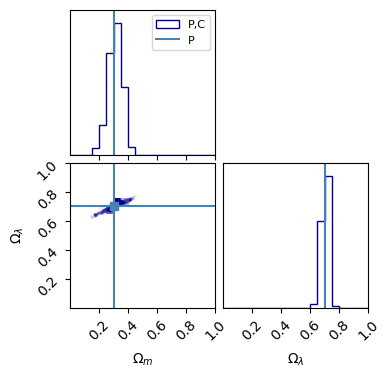

In [ ]:
truth_dict = {'OM':float(default_cosmo.Omega_c),
            'Ok':float(default_cosmo.Omega_k),
            'Ode':1-float(default_cosmo.Omega_c+default_cosmo.Omega_k),
            'w':float(default_cosmo.w0),
            'wa':float(default_cosmo.wa),
            'mu_zL_g_L':float(np.mean(zL_obs)),'mu_zS_g_L':float(np.mean(zS_obs)),
            'sigma_zL_g_L':float(np.std(zL_obs)),'sigma_zS_g_L':float(np.std(zS_obs)),
            'mu_zL_g_NL':np.nan,'mu_zS_g_NL':np.nan,
            'sigma_zL_g_NL':np.nan,'sigma_zS_g_NL':np.nan,
            't':0.2,'t_mu':1.0
            }
def plot_MCMC(sampler_list,key_list=[],prog=False,plot_corner=False,legend_list=[],plot_Ok=False):
    if not isinstance(sampler_list, list):
        print('Making into a list')
        sampler_list=[sampler_list]
    if len(key_list)==0: #Plotting all except zL, zS 
        key_list=list(sampler_list[0].get_samples(group_by_chain=True).keys())
        try:key_list.remove('zL');key_list.remove('zS')
        except: pass
    print('Keys:',key_list)
    dO = 0.01;dZ = 0.1
    print('NOTE: Need to change this so the bins cover the whole prior:')
    bin_dict = {'OM':np.arange(0,1+dO,dO),'Ode':np.arange(0,1+dO,dO),'Ok':np.arange(-1,1+dO,dO),
                'w':np.arange(-1.6,0.1,0.1),'wa':np.arange(-4.5,2.1,0.1),
                'mu_zL_g_L':np.arange(0,1.5+dZ,dZ),'mu_zS_g_L':np.arange(0,3+dZ,dZ),
                'mu_zL_g_NL':np.arange(0,5.1,0.1),'mu_zS_g_NL':np.arange(0,5.1,0.1),
                'sigma_zL_g_L':np.arange(0,2.1,0.1),'sigma_zS_g_L':np.arange(0,2.1,0.1),
                'sigma_zL_g_NL':np.arange(0.1,5.1,0.1),'sigma_zS_g_NL':np.arange(0.1,5.1,0.1),
                'zL':np.arange(0,1.5+dZ,dZ),'zS':np.arange(0,3+dZ,dZ),
                't':np.arange(0,2.1,0.1),'t_mu':np.arange(0,2.1,0.1)}
    range_dict = {'OM':(0,1),'Ode':(0,1),'Ok':(-1,1),
                'w':(-1.6,0.1),'wa':(-4.5,2),
                'mu_zL_g_L':(0,1.5),'mu_zS_g_L':(0,3),
                'mu_zL_g_NL':(0,5),'mu_zS_g_NL':(0,5),
                'sigma_zL_g_L':(0,2),'sigma_zS_g_L':(0,2),
                'sigma_zL_g_NL':(0.1,5),'sigma_zS_g_NL':(0.1,5),
                'zL':(0,1.5),'zS':(0,3),'t':(0,2),'t_mu':(0,2)}
    title_dict = {'OM':'$\Omega_m$','Ode':'$\Omega_\lambda$','Ok':'$\Omega_k$',
                'w':'$w_0$','wa':'$w_a$',
                'mu_zL_g_L':'$\mu_{zL|L}$','mu_zL_g_NL':'$\mu_{zL|NL}$',
                'mu_zS_g_L':'$\mu_{zS|L}$','mu_zS_g_NL':'$\mu_{zS|NL}$',
                'sigma_zL_g_L':'$\sigma_{zL|L}$','sigma_zL_g_NL':'$\sigma_{zL|NL}$',
                'sigma_zS_g_L':'$\sigma_{zS|L}$','sigma_zS_g_NL':'$\sigma_{zS|NL}$',
                't':'Test Sampler','t_mu':'Test Sampler ($\mu$)'
                }
    hist_dict = {'density':False,'color':'darkblue','edgecolor':'k'}
    X_dim = np.min([6,len(key_list)])
    Y_dim = 2*np.max([np.ceil(len(key_list)/X_dim).astype('int'),1])
    N_chains = sampler_list[0].num_chains
    if prog:
        for s_i,sampler in enumerate(sampler_list):
            fig,ax = pl.subplots(Y_dim,X_dim,figsize=(5*X_dim,5*Y_dim))
            for p_i,k_i in enumerate(key_list):
                x,y = 2*np.floor(p_i/X_dim).astype('int'),p_i%X_dim
                ax[x,y].hist(sampler.get_samples()[k_i][:,0],bins=bin_dict[k_i],**hist_dict)
                mean_i = '{0:.2f}'.format(np.round(np.mean(sampler.get_samples()[k_i][:,0]),3))
                std_i = '{0:.2f}'.format(np.round(np.std(sampler.get_samples()[k_i][:,0]),3))
                ax[x,y].set_title(title_dict[k_i]+', $\mu$:'+mean_i+', $\sigma$: '+std_i,fontsize=15)
                for i in range(2):
                    ax[x+1,y].plot(sampler.get_samples(group_by_chain=True)[k_i][i,:,0],alpha=0.5,
                                c=pl.cm.viridis(np.linspace(0,1,1+N_chains)[i]))
            pl.tight_layout()
            pl.suptitle(f'Sampler {s_i}')
            pl.show()
    if plot_corner:
        fig,ax = pl.subplots(len(key_list)+plot_Ok,len(key_list)+plot_Ok,figsize=(2*len(key_list),2*len(key_list)))
        for s_i,sampler in enumerate(sampler_list):
            if s_i == len(sampler_list)-1: truths=[truth_dict[k] for k in key_list]
            else: truths=None
            try: 
                corner_samples = np.array([sampler.get_samples()[k][:,0] for k in key_list]).T
                if plot_Ok:
                    Ok = np.array([1-(sampler.get_samples()['OM'][:,0]+sampler.get_samples()['Ode'][:,0])]).T
                    corner_samples = np.concatenate([corner_samples,Ok],axis=1)
                    key_list.append('Ok')
            except Exception as ex:
                print(ex) 
                N_steps = sampler.chain.shape[1]
                print(f'Sampler took {N_steps} steps - using 50% burnin')
                corner_samples = np.array(sampler.chain[:,int(N_steps/2):,:])
            corner.corner(corner_samples,
            labels=[title_dict[k] for k in key_list],
            truths=truths,
            #truth_color='darkblue',
            fig=fig,
            color=['darkblue','darkred','darkgreen','purple'][s_i],
            range=[range_dict[k] for k in key_list],
            bins=20)
        if len(legend_list)!=0: ax[0,0].legend(legend_list,fontsize=8)
        pl.show()
        if plot_Ok: print("Note: Ok is not an independent variable, so shouldn't be plotted as if it is.")

plot_MCMC([sampler_S],
            #sampler_b,sampler_c,sampler_d],
            prog=False,plot_corner=True,key_list=['OM','Ode'],#,'w','wa'],
            legend_list = ['P,C','P','C','Spec'],
            plot_Ok=False)#,'sigma_zL_g_L'])
#plot_MCMC([sampler_test,sampler],prog=False,plot_corner=True,key_list=['t_mu','t_mu'])

In [ ]:
'''
Function to demonstrate that the MCMC sampling can produce marginalisation over a variable, in the case of gaussian distributions:
Define a distribution:
L_integrand = e^[-((mu-z)^2+(t-z)^2)]
Will marginalise over mu:
L = Integral(L_integrand d_mu) between 0<mu<5.
Defining z = 0.8 (arbitrary):
L = 1.543897 * e^[-(t-z)^2] (calculated analytically)
Will use MCMC to produce samples from L_integrand, then demonstrate that using only the t (=theta) samples effectively marginalises
over mu.
'''
from scipy.integrate import quad
from matplotlib.colors import LogNorm

def marginalisation_proof_1():
    def L_integrand(mu,theta,z_obs):
        P_1 = np.prod(np.exp(-(mu-z_obs)**2))
        P_2 = np.prod(np.exp(-(theta-z_obs)**2))
        Int = P_1*P_2
        return Int
    z_obs_toy = np.array([0.8])
    #MCMC sampling of the L_integrand distribution (re-written below):
    def test_MCMC_simple(N_steps,z_obs):
        def log_likelihood(mu,theta,z_obs):
            chi1 = (theta-z_obs)**2 #Set sigma=1
            chi2 = (mu-z_obs)**2 #Set sigma=1
            L1 = (1/np.sqrt(2*np.pi))*np.exp(-chi1)
            L2 = (1/np.sqrt(2*np.pi))*np.exp(-chi2)
            return np.log(L1*L2)
        def log_prior(mu,theta):
            if mu>5 or mu<0:
                return -np.inf
            if theta>10 or theta<0:
                return -np.inf
            else: return 0
        def log_posterior(mu_theta,z_obs):
            mu=mu_theta[0];theta=mu_theta[1]
            lp = log_prior(mu,theta)
            lp += log_likelihood(mu,theta,z_obs)
            return lp
        nwalkers, ndim = 50, 2
        cur_mu = np.random.uniform(0,5,size=(nwalkers,1))
        cur_theta = np.random.uniform(0,10,size=(nwalkers,1))
        cur_state = np.concatenate([cur_mu,cur_theta],axis=1)
        sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior,args=(z_obs,))
        sampler.run_mcmc(cur_state, N_steps, progress=True)
        return sampler
    sampler_simple = test_MCMC_simple(20000,z_obs_toy)
    ####
    ####
    theta_list = np.linspace(0,10,100)
    #The following function numerically integrates over mu, between 0 and 5, for a range of different values for theta.
    #These are compared to the MCMC samples: 
    g_theta_list = np.array([quad(L_integrand,a=0,b=5,args=(theta_i,z_obs_toy))[0] for theta_i in theta_list])
    #Plot the numerical result of marginalising over mu. We want the density function, so we **divide** by 1.54, which is the
    #integral of Int(exp(t-z) dt) between 0<t<10.
    pl.plot(theta_list,np.array(g_theta_list)/1.54**2,label='Numerical Integral') #Divide by 1.54^2 here as integrating over mu 
    #produces one factor of 1.54, and integrating over theta would give another factor. We want a density function.
    pl.plot(theta_list,np.exp(-(theta_list-z_obs_toy)**2)/1.54,'--',c='k',label='Analytic Integral')
    pl.xlabel('$\\theta$')
    pl.ylabel('g($\\theta$)')
    pl.hist(sampler_simple.chain[:,500:,1].flatten(),density=True,bins=100,alpha=0.5,label='MCMC Samples')
    pl.legend()
    pl.show()
    #Now plotting the 2D L_integrand distribution, from the MCMC sampling and the L_integrand function itself. 
    fig,ax = pl.subplots(1,2,figsize=(10,5))
    ax[0].hist2d(x=sampler_simple.chain[:,500:,0].flatten(),y=sampler_simple.chain[:,500:,1].flatten(),bins=20)
    X_plot,Y_plot = np.meshgrid(np.linspace(0,5,100),np.linspace(0,10,100))
    L_integrand_vec = np.vectorize(L_integrand)
    L_plot = L_integrand_vec(X_plot,Y_plot,z_obs_toy)
    ax[1].imshow(L_plot,extent=[0,5,0,10],origin='lower')
    for i in range(2):
        ax[i].set_xlabel('$\mu$')
        ax[i].set_ylabel('$\\theta$')
    ax[1].set_ylim(0,4);ax[0].set_ylim(0,4)
    ax[1].set_xlim(0,4);ax[0].set_xlim(0,4)
    pl.show()

marginalisation_proof_1()

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:04<00:00, 2182.98it/s]


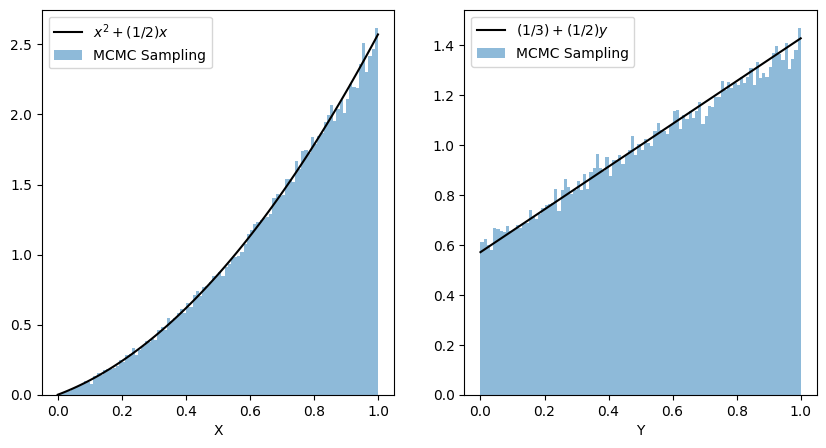

In [ ]:
'''
Function to demonstrate that the MCMC can marginalise over a function which cannot be separated into the product of the two variables.
We use f(x,y) = x(x+y), defined over x=[0,1] and y=[0,1]
Marginalising over y:
Int_0 = [x^2*y + 0.5*xy^2], evaluated at [0,1]
      = x^2 + 0.5*x
Further integrating over x:
Int_1 = 1/3 + 1/4 = 7/12
Alternatively, originally marginalising over x:
Int_2 = [1/3x^3 + 1/2x^2*y], evaluated at [0,1]
      = 1/3 + (1/2)*y
Further integrating over y:
Int_3 = 1/3 + 1/4 = 7/12 (=Int_1, as expected).
'''
def marginalisation_proof_2():
    def likelihood_x(x,y):
        if x<=0: return -np.inf
        if y<=0: return -np.inf
        l_i =  np.log(x*(x+y))
        return l_i
    def prior_xy(x,y):
        if x<=0 or x>1: return -np.inf
        if y<=0 or y>1: return -np.inf
        else: return 0
    def posterior_x(xy):
        x=xy[0];y=xy[1]
        lp = prior_xy(x,y)
        lp+=likelihood_x(x,y)
        return lp
    cur_x = np.random.uniform(0,1,size=(30,1))
    cur_y = np.random.uniform(0,1,size=(30,1))
    cur_xy = np.concatenate([cur_x,cur_y],axis=1)
    N_steps = 10000
    sampler_x2 = emcee.EnsembleSampler(30, 2, posterior_x)
    sampler_x2.run_mcmc(cur_xy, N_steps, progress=True)
    fig,ax = pl.subplots(1,2,figsize=(10,5))
    X_plot = np.linspace(0,1,100)
    #Multiply by (12/7) as want a probability density function, so need area=1
    ax[0].plot(X_plot,(12/7)*(X_plot**2+0.5*X_plot),c='k',label='$x^2 + (1/2)x$')
    ax[0].hist(sampler_x2.chain[:,1000:,0].flatten(),bins=100,density=True,alpha=0.5,label='MCMC Sampling')
    ax[0].set_xlabel('X')
    ax[0].legend()
    Y_plot = np.linspace(0,1,100)
    #Multiply by (12/7) as want a probability density function, so need area=1
    ax[1].plot(Y_plot,(12/7)*((1/3)+0.5*Y_plot),c='k',label='$(1/3) + (1/2)y$')
    ax[1].hist(sampler_x2.chain[:,1000:,1].flatten(),bins=100,density=True,alpha=0.5,label='MCMC Sampling')
    ax[1].set_xlabel('Y')
    ax[1].legend()
    pl.show() #Conclusion: emcee returns samples from whatever function I supply it with (not the integral of it, or anything else).
    #The 'Integration' can be done with just ignoring the dimension to be integrated over - will need to check in what circumstances
    #this applies, e.g. uniform vs gaussian priors. Will also need to check why the gaussian test integral (above) doesn't work.

marginalisation_proof_2()

100%|██████████| 5000/5000 [00:09<00:00, 537.98it/s]


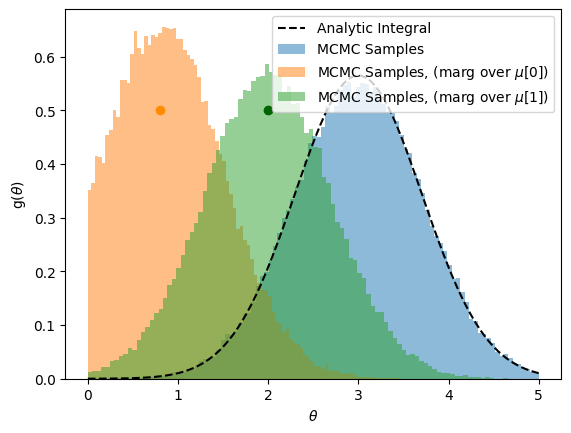

In [ ]:
'''
Function to demonstrate that the MCMC sampling can produce marginalisation over >1 variable, in the case of gaussian distributions:
Define a distribution:
L_integrand = e^[-((mu-z)^2+(t-q)^2)] where mu and z are now 2D vectors.
i.e.
L_integrand = e^[-(mu_0-z0)^2 + (mu_1-z1)^2 + (t-q)^2]
Will marginalise over mu:
L = Integral(L_integrand d_mu) between 0<mu_0<5,0<mu_1<5.
Defining z = [0.8,2.0] (arbitrary) and q = [3] (also arbitrary)
L = 0.115649674302 * e^[-(t-q)^2] (calculated numerically, from Desmos)
Will use MCMC to produce samples from L_integrand, then demonstrate that using only the t (=theta) samples effectively marginalises
over mu.
'''
from scipy.integrate import quad
from matplotlib.colors import LogNorm

def marginalisation_proof_3():
    z_obs_toy = np.array([0.8,2])
    q_obs_toy = np.array([3])
    #MCMC sampling of the L_integrand distribution (re-written below):
    def test_MCMC_simple_2D(N_steps,z_obs,q_obs):
        def log_likelihood(mu,theta,z_obs,q_obs):
            chi1 = (theta-q_obs)**2 #Set sigma=1
            chi2 = (mu-z_obs)**2 #Set sigma=1
            assert len(np.array(chi1))==1
            assert len(np.array(chi2))==2
            return -(np.sum(chi2)+chi1)
        def log_prior(mu,theta):
            assert len(mu)==2;assert len(theta)==1
            if mu[0]>5 or mu[0]<0: return -np.inf
            if mu[1]>5 or mu[1]<0: return -np.inf
            if theta>5 or theta<0: return -np.inf
            else: return 0
        def log_posterior(mu_theta,z_obs,q_obs):
            mu = mu_theta[0:2]
            theta = np.array([mu_theta[2]])
            lp = log_prior(mu,theta)
            lp += log_likelihood(mu,theta,z_obs,q_obs)
            return lp
        nwalkers, ndim = 50, 3
        cur_mu_0 = np.random.uniform(0,5,size=(nwalkers,1))
        cur_mu_1 = np.random.uniform(0,5,size=(nwalkers,1))
        cur_theta = np.random.uniform(0,5,size=(nwalkers,1))
        cur_state = np.concatenate([cur_mu_0,cur_mu_1,cur_theta],axis=1)
        sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior,args=(z_obs,q_obs))
        sampler.run_mcmc(cur_state, N_steps, progress=True)
        return sampler
    sampler_simple = test_MCMC_simple_2D(5000,z_obs_toy,q_obs_toy)
    ####
    ####
    theta_list = np.linspace(0,5,100)
    #Dividing by 1.77 (=Integral of e^[-(t-3)^2] for 0<t<5), to give a probability density function
    pl.plot(theta_list,np.exp(-(theta_list-q_obs_toy)**2)/1.77,'--',c='k',label='Analytic Integral')
    pl.xlabel('$\\theta$')
    pl.ylabel('g($\\theta$)')
    pl.hist(sampler_simple.chain[:,1000:,2].flatten(),density=True,bins=100,alpha=0.5,label='MCMC Samples')
    #Adding in these extra histograms as a quick check, showing when marginalising over the other two parameters, you recover 
    #distributions centered on z_obs[0] and z_obs[1].
    pl.hist(sampler_simple.chain[:,1000:,0].flatten(),density=True,bins=100,alpha=0.5,label='MCMC Samples, (marg over $\mu$[0])')
    pl.hist(sampler_simple.chain[:,1000:,1].flatten(),density=True,bins=100,alpha=0.5,label='MCMC Samples, (marg over $\mu$[1])')
    pl.scatter(z_obs_toy[0],0.5,c='darkorange')
    pl.scatter(z_obs_toy[1],0.5,c='darkgreen')
    pl.legend()
    pl.show()

marginalisation_proof_3()

In [3]:
from marginalisation_test import marginalisation_test
import sys
#Code to reload elliptical_lens_galaxies:
from importlib import reload
reload(sys.modules['marginalisation_test'])
from marginalisation_test import marginalisation_test,marginalisation_test_no_parent,r_func,posterior_x
from scipy.stats import norm
import subprocess
import matplotlib.pyplot as pl
import pandas as pd
import numpy as np
from seaborn import kdeplot
sigma_dict = {'z':0.2,
              'r':5}
N_obs = 5
print(f'Input arguments: {N_obs}, {sigma_dict["z"]}')

O_test = 0.3
zL_true_test = 20*np.ones(N_obs)#np.array(norm(20,0.001).rvs(size=N_obs))

obs_dict = {
    'z':norm(zL_true_test,sigma_dict['z']).rvs(),
    'r':norm(r_func(zL_true_test,O_test),sigma_dict['r']).rvs()}

# s_test,N_walkers = marginalisation_test(obs_dict['z'],obs_dict['r'],
#                               sigma_dict['z'],sigma_dict['r'],N_steps=5000,verbose=False)


Input arguments: 5, 0.2


In [42]:
chain_dict = {}
for n_chain in range(s_test.get_chain().shape[1]):
    for n_z in np.arange(3,s_test.get_chain().shape[2]):
        chain_dict[f'z_{n_z}_{n_chain}'] = s_test.get_chain()[:,n_chain,n_z]
    chain_dict[f'theta_{n_chain}'] = s_test.get_chain()[:,n_chain,0]
    chain_dict[f'mu_z_{n_chain}'] = s_test.get_chain()[:,n_chain,1]
    chain_dict[f'sigma_z_{n_chain}'] = s_test.get_chain()[:,n_chain,2]

db_test = pd.DataFrame(chain_dict)[[f'theta_{ii}' for ii in range(N_walkers)]]
db_test

,theta_0,theta_1,theta_2,theta_3,theta_4,theta_5,theta_6,theta_7,theta_8,theta_9,...,theta_36,theta_37,theta_38,theta_39,theta_40,theta_41,theta_42,theta_43,theta_44,theta_45
0,0.270022,0.603741,0.596375,0.345396,0.394865,0.853971,0.586683,0.638894,0.499797,0.365719,...,0.568996,0.494152,0.159321,0.705162,0.128570,0.611340,0.549462,0.082625,0.525539,0.451717
1,0.270022,0.603741,0.596375,0.345396,0.394865,0.759203,0.586683,0.638894,0.536487,0.365719,...,0.568996,0.494152,0.159321,0.705162,0.140115,0.611802,0.549462,0.082625,0.525539,0.451717
2,0.270022,0.589607,0.596375,0.345396,0.397966,0.689761,0.586683,0.638894,0.536487,0.365719,...,0.568996,0.512687,0.159321,0.705162,0.140115,0.500717,0.549462,0.082625,0.525539,0.460096
3,0.270022,0.615335,0.596375,0.345396,0.397966,0.728601,0.579253,0.658039,0.538793,0.365719,...,0.568996,0.512687,0.110195,0.459642,0.140115,0.500717,0.541484,0.082625,0.525539,0.418843
4,0.270022,0.615335,0.480308,0.231473,0.397966,0.678870,0.579253,0.658039,0.365694,0.326755,...,0.568996,0.512687,0.110195,0.466356,0.140115,0.500717,0.548388,0.022131,0.525539,0.418843
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.070712,0.069792,0.070854,0.069263,0.070150,0.069729,0.068654,0.070687,0.070527,0.069288,...,0.072100,0.068359,0.070191,0.069166,0.072202,0.069732,0.068371,0.068436,0.070269,0.069688
996,0.070452,0.069690,0.070854,0.069263,0.070004,0.069729,0.068714,0.070687,0.070453,0.069287,...,0.071953,0.068359,0.070191,0.069166,0.072202,0.069732,0.068371,0.068572,0.070049,0.069688
997,0.070530,0.069690,0.070854,0.069263,0.069992,0.069729,0.068714,0.070687,0.070453,0.069287,...,0.071953,0.068359,0.070191,0.069166,0.072202,0.069668,0.069256,0.068572,0.070049,0.069684
998,0.070530,0.069690,0.070854,0.069797,0.069992,0.069729,0.068542,0.070689,0.070453,0.069287,...,0.071077,0.068421,0.070191,0.069166,0.071752,0.069574,0.069238,0.068181,0.070049,0.069693


In [ ]:
def add_to_queue():
    for N_obs_i in N_obs_list:
        for sigma_i in sigma_list:
            subprocess.run("addqueue -c '1hr' -m 10 -q blackhole "+\
                f"/mnt/users/hollowayp/python11_env_new/bin/python3.11 "+\
                #f"./JAX_Trial_MCMC_toy_model.py {N_obs_i} {sigma_i} emcee 50000",
                f"./JAX_Trial_MCMC_toy_model.py {N_obs_i} {sigma_i} jax 10000 5000 True",                
                shell=True)

def plot_chains(method_str='',ax=None): #method_str=jax if jax or "" if emcee.
    if ax is None: fig,ax = pl.subplots(len(N_obs_list),len(sigma_list)+1,figsize=(5*(len(sigma_list)+1),5*len(N_obs_list)))  
    for x,N_obs in enumerate(N_obs_list):
        db_ii = {}
        for y,sigma in enumerate(sigma_list):
            try:
                db_i = pd.read_csv(f'/mnt/zfsusers/hollowayp/zBEAMS/chains/MCMC_tests/MCMC_toy_'+\
                    f'{method_str}_'*(method_str=="JAX")+f'{N_obs}_{sigma}.csv')
                N_steps = len(db_i)  
                ax[x,y].plot(db_i,alpha=0.05,c=color_dict[method_str])
                db_ii['$\sigma$: '+str(sigma)] = np.array(db_i.loc[N_steps//2:]).flatten()
            except Exception as ex: print(ex)
            ax[x,y].set_title(f'N_obs: {N_obs}, ' + '$\sigma$: ' + f'{sigma}')
            ax[x,y].set_ylim([0,1])
            ax[x,y].plot([0,5000],[O_test,O_test],'--',c='k')
        kdeplot(db_ii,ax=ax[x,4],linestyle=line_dict[method_str],common_norm=False)
        ax[x,4].set_xlim(0.1,0.7)
        ax4_ylim = ax[x,4].get_ylim();ax[x,4].set_ylim(ax4_ylim)
        ax[x,4].plot([O_test,O_test],ax4_ylim,c='k')
        ax[x,4].set_xlabel('P($\Omega$|{D})',fontsize=12)

import subprocess 
N_obs_list = [2,5,10,20,100]
#sigma_list = np.array([0.2,1.0,5,10]).astype('float64')
sigma_list = np.array([4,5,6,7]).astype('float64')

color_dict = {'JAX':'darkred','emcee':'darkblue'}
line_dict = {'JAX':'-','emcee':'--'}

#add_to_queue()

[Errno 2] No such file or directory: '/mnt/zfsusers/hollowayp/zBEAMS/chains/MCMC_tests/MCMC_toy_100_4.0.csv'
[Errno 2] No such file or directory: '/mnt/zfsusers/hollowayp/zBEAMS/chains/MCMC_tests/MCMC_toy_100_5.0.csv'
[Errno 2] No such file or directory: '/mnt/zfsusers/hollowayp/zBEAMS/chains/MCMC_tests/MCMC_toy_100_6.0.csv'
[Errno 2] No such file or directory: '/mnt/zfsusers/hollowayp/zBEAMS/chains/MCMC_tests/MCMC_toy_100_7.0.csv'


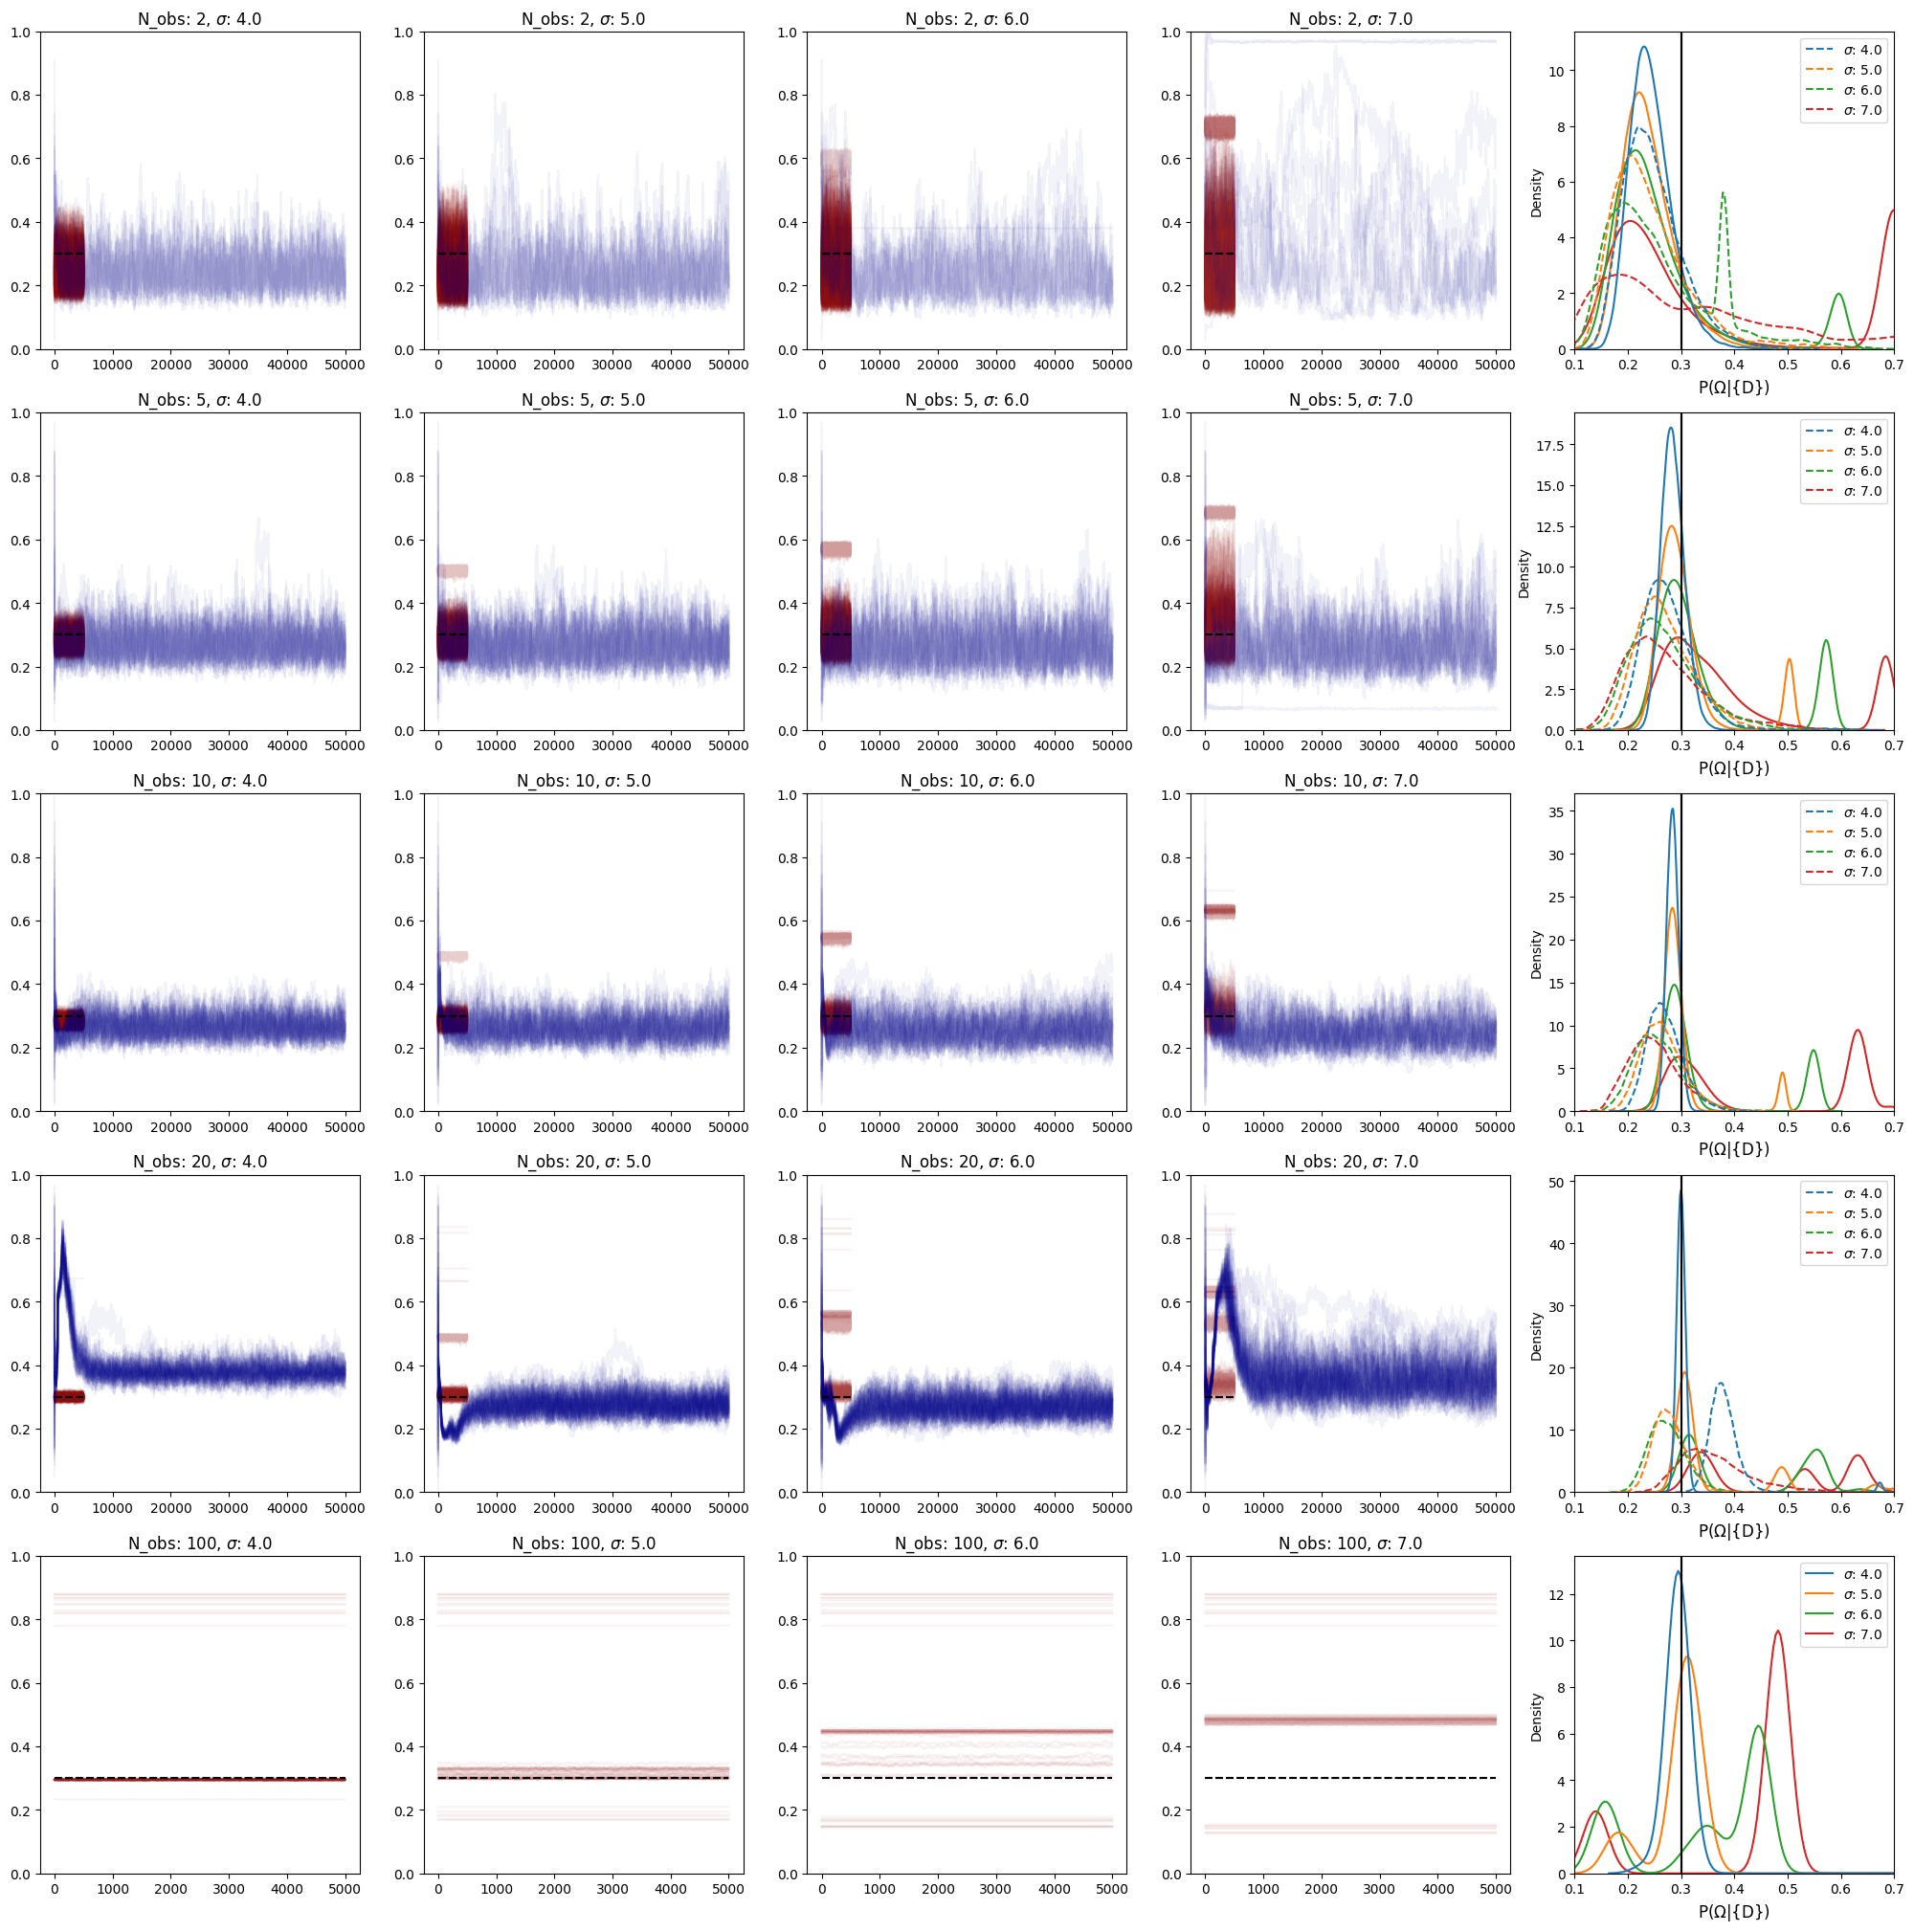

In [18]:
fig,ax = pl.subplots(len(N_obs_list),len(sigma_list)+1,figsize=(5*(len(sigma_list)+1),5*len(N_obs_list))) 
plot_chains('JAX',ax=ax)
plot_chains('emcee',ax=ax)
pl.show()

In [6]:
import glob
glob.glob('/mnt/zfsusers/hollowayp/zBEAMS/chains/MCMC_tests/MCMC_toy_100*')

[]

In [29]:
reload(sys.modules['marginalisation_test'])
from marginalisation_test import j_marginalisation,run_MCMC_marginalisation

sigma_z_obs = 5
sigma_r_obs = 5
N_obs = 100
zL_true_test = np.array(norm(20,5).rvs(size=N_obs))

obs_dict = {
    'z':norm(zL_true_test,sigma_z_obs).rvs(),
    'r':norm(r_func(zL_true_test,O_test),sigma_r_obs).rvs()}

jax_sampler = run_MCMC_marginalisation(obs_dict['z'],obs_dict['r'],sigma_z_obs,sigma_r_obs,
                            num_chains = 20,
                            num_warmup = 10000,
                            num_samples = 2000,
                            target_accept_prob=0.99)

Target Accept Prob: 0.99
SHAPES (100,) (100,) (100,) (100,)
Uncompiled time 0.008318424224853516
Compiled time 0.00374603271484375


/mnt/users/hollowayp/zBEAMS/marginalisation_test.py:140: UserWarning: There are not enough devices to run parallel chains: expected 20 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(20)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  sampler_0 = MCMC(inner_kernel,#outer_kernel,
sample: 100%|██████████| 2000/2000 [00:01<00:00, 1418.87it/s, 127 steps of size 2.82e-02. acc. prob=0.99]


In [25]:
jax_sampler.get_samples(True)['theta'].shape

(10, 1000, 1)

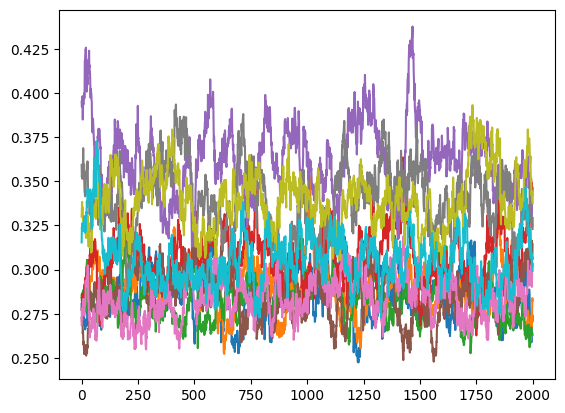

In [30]:
for c_i in range(10):
    pl.plot(jax_sampler.get_samples(True)['theta'][c_i,:,0].T)
pl.show()

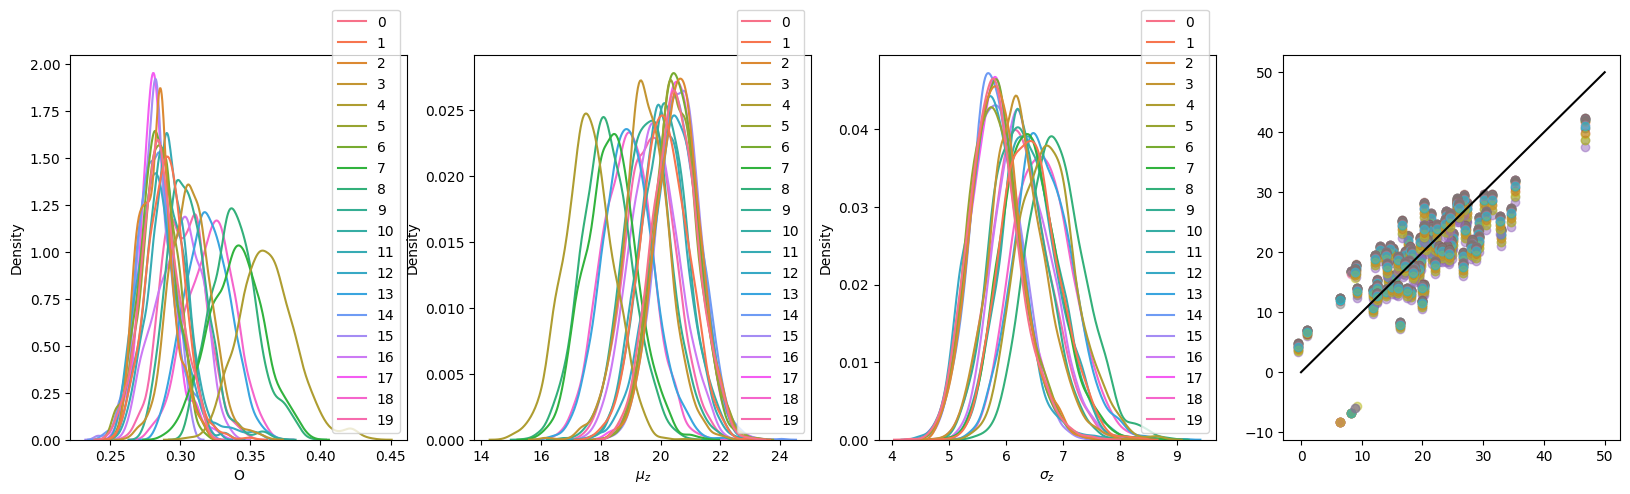

In [31]:
N_steps = 0#1000
N_chains = jax_sampler.get_samples(True)['theta'].shape[0]
fig,ax = pl.subplots(1,4,figsize=(20,5))
kdeplot(jax_sampler.get_samples(True)['theta'][:,N_steps//2:,0].T,ax=ax[0])
kdeplot(jax_sampler.get_samples(True)['mu_z'][:,N_steps//2:,0].T,ax=ax[1])
kdeplot(jax_sampler.get_samples(True)['sigma_z'][:,N_steps//2:,0].T,ax=ax[2])
for i in range(3):
    ax[i].set_xlabel(['O','$\mu_z$','$\sigma_z$'][i])
for obs_i in range(len(obs_dict['r'])):
    for chain_i in range(N_chains):
        ax[3].scatter(obs_dict['z'][obs_i],jax_sampler.get_samples(True)['z_true'][chain_i,N_steps:,0,obs_i].T.mean(),alpha=0.5)
ax[3].plot([0,50],[0,50],c='k')
pl.show()


#### Code for analytic and emcee toy model moved to JAX_Trial_MCMC_toy_model_analytic.py

While useful, I think this method, without the parent hyperparameters, doesn't have an accurate prior on P(z). It is uniform over a very large parameter space, and thus doesn't favour/disfavour values of z far from the true value. 
Also, need to check the maths isn't wrong for the no_parent marginalisation, i.e. that I am not finding the product of an integral, rather than the integral (over z_true) of a product (from multiple measurements).

In [59]:
N_obs = 50
sigma_z_obs = 10
sigma_r_obs = 5
zL_true_test=20
db_analytic = pd.read_csv(f'/mnt/zfsusers/hollowayp/zBEAMS/chains/MCMC_tests/MCMC_toy_analytic_{N_obs}_{float(sigma_z_obs)}.csv')
db_emcee = pd.read_csv(f'/mnt/zfsusers/hollowayp/zBEAMS/chains/MCMC_tests/MCMC_toy_emcee_{N_obs}_{float(sigma_z_obs)}.csv')
db_emcee_z = pd.read_csv(f'/mnt/zfsusers/hollowayp/zBEAMS/chains/MCMC_tests/MCMC_toy_emcee_z_{N_obs}_{float(sigma_z_obs)}.csv')

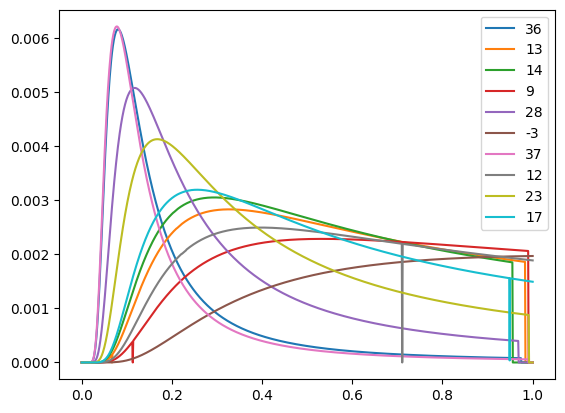

In [18]:
for i in range(10):
    pl.plot(O_list,db_analytic[str(i)],label=int(obs_dict['z'][i]))
pl.legend()
pl.show()

In [109]:
#NOTE THIS ASSUMES ONLY A SINGLE TRUE VALUE OF Z_TRUE, NOT ONE DRAWN HIERARCHICALLY FROM A PARENT POPULATION.
def generate_obs_dict(sigma_z_obs,sigma_r_obs,N_obs):
    print('Sigma values',sigma_z_obs,sigma_r_obs)
    np.random.seed(1)
    obs_dict = {
        'z':norm(zL_true_test,sigma_z_obs).rvs(size=N_obs),
        'r':norm(r_func(zL_true_test,O_test),sigma_r_obs).rvs(size=N_obs)}
    return obs_dict

obs_dict = generate_obs_dict(sigma_z_obs,sigma_r_obs,50)

Sigma values 10 5


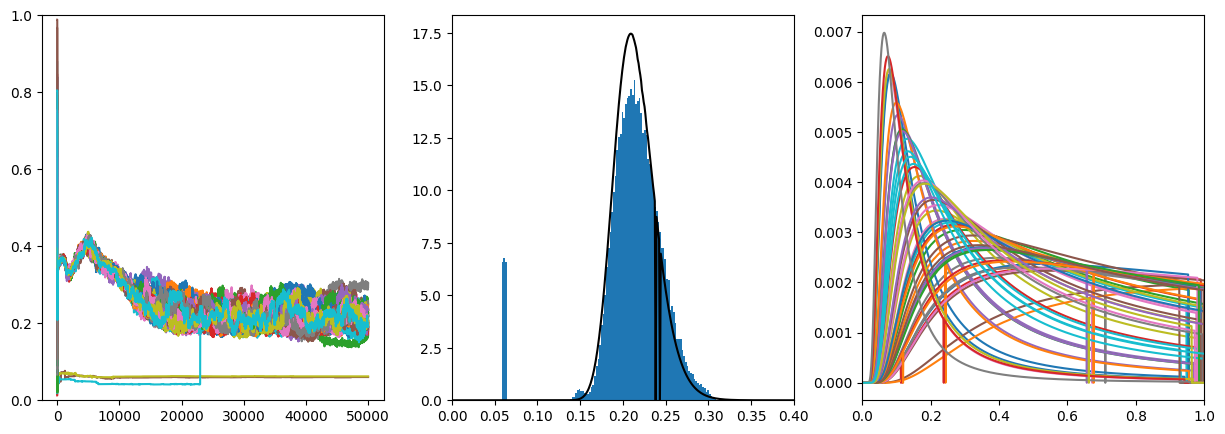

In [10]:
burnin = 30000
O_list = np.linspace(0,1,1000)
fig,ax = pl.subplots(1,3,figsize=(15,5))
ax[0].plot(db_emcee)
ax[0].set_ylim(0,1)
ax[1].hist(np.array(db_emcee.loc[burnin:]).flatten(),bins=np.linspace(0.0,1,500),density=True)

for obs_i in range(N_obs):
    ax[2].plot(O_list,db_analytic[str(obs_i)])#/np.max(db_analytic[str(obs_i)]),alpha=0.5)

Posterior = np.prod([db_analytic[str(elem)] for elem in range(N_obs)],axis=0)
#ax[2].plot(O_list,Posterior/np.max(Posterior),c='k')
h = 1/len(Posterior)
ax[1].plot(O_list,Posterior/(h*np.sum(Posterior)),c='k')
#ax[2].plot([O_test,O_test],[0,1],'--',c='k')
ax[2].set_xlim(0.0,1)
ax[1].set_xlim(0.0,0.4)
pl.show()

#WHAT ABOUT DEGENERACY BETWEEN Z_TRUE AND O_TEST? NEED TO PLOT CONTOUR PLOT OF THESE INSTEAD?

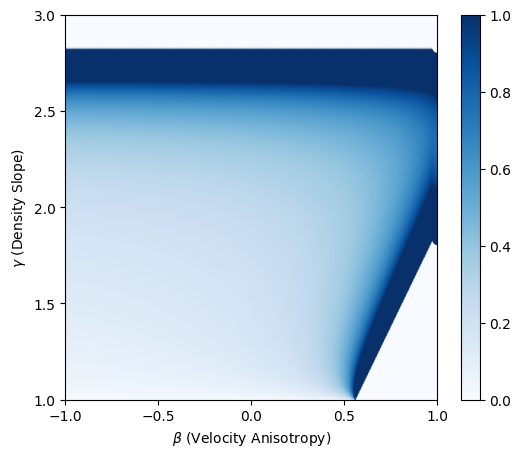

In [46]:
from Eqn_6_from_Li_2023 import f_Eqn_6
##Verifying the imported equation matches Figure 2 in Tian's paper:
g,b = np.meshgrid(np.linspace(1,3,1000),np.linspace(-1,1,1000))
fig = pl.figure(figsize=(6,5))
pl.scatter(b,g,c=f_Eqn_6(g,2.173,b),cmap='Blues',vmin=0,vmax=1)
pl.xlabel('$\\beta$ (Velocity Anisotropy)')
pl.ylabel('$\gamma$ (Density Slope)')
pl.xlim(-1,1);pl.ylim(1,3)
pl.xticks(np.arange(-1,1.5,0.5))
pl.yticks(np.arange(1,3.5,0.5))
pl.colorbar()
pl.show()

In [115]:
from importlib import reload
import sys
sys.path.append('/Users/hollowayp/zBEAMS/')
import marginalisation_test
reload(sys.modules['marginalisation_test'])
from marginalisation_test import j_marginalisation,run_MCMC_marginalisation
import jax.numpy as jnp 
import numpyro
from numpyro import distributions as dist
from jax.random import PRNGKey


In [22]:
a = run_MCMC_marginalisation(jnp.array([1,2,3]),jnp.array([10,20,30]),1,2)


/mnt/users/hollowayp/zBEAMS/marginalisation_test.py:133: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  sampler_0 = MCMC(inner_kernel,#outer_kernel,


Target Accept Prob: 0.8
Uncompiled time 0.007657051086425781
Compiled time 0.004791259765625


  0%|          | 0/1000 [00:00<?, ?it/s]

sample: 100%|██████████| 1000/1000 [00:00<00:00, 2710.62it/s, 15 steps of size 2.36e-01. acc. prob=0.94]


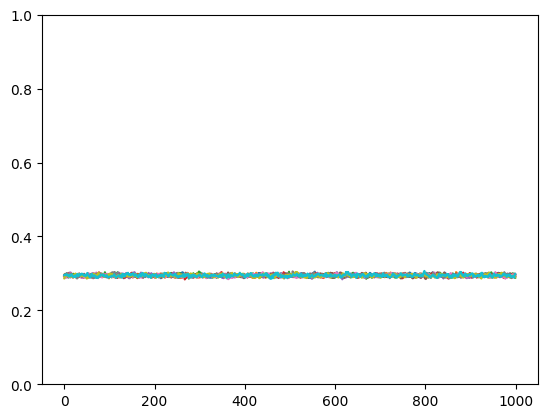

In [45]:
import matplotlib.pyplot as pl
pl.plot(pd.read_csv('/mnt/zfsusers/hollowayp/zBEAMS/chains/MCMC_tests/MCMC_toy_JAX_100_1.0.csv'))
pl.ylim(0,1)
pl.show()

In [34]:
import pandas as pd


,theta_0,theta_1
0,0.983742,0.983515
1,0.983742,0.973742
2,0.992342,0.964665
3,0.943907,0.914044
4,0.960963,0.974000
...,...,...
995,0.955852,0.991445
996,0.946242,0.987838
997,0.934323,0.989538
998,0.952005,0.996552
